14 October 2024 <br>
Mufarowashe Chiyangwa <br>
ST10261507 <br>
PDAN8412w
<br>
<br>
<br>
<br>
# POE Task 2 - Applying logistic regression from scratch
<br>

## 1. What is logistic regression?

Logistic regression is a data analysis technique that finds the relationship between input variables and an output variable using statistical and probabilistic mathematics, then uses this relationship to predict the output variable. The predicted output usually has a “finite number of outcomes, like yes or no” (Amazon Web Services, 2024).

Advantages of logistic regression:
- Simplicity: logistic regression models are less complex and easier to understand as compared to most machine learning models, so they can be implemented in an environment where not all stakeholders have a data science/mathematical/statistical expertise (Amazon Web Services, 2024).
- Speed: logistic regression models don't require a lot of computational capacity because of their relative mathematical simplicity so they can process data at a faster rate (Amazon Web Services, 2024).
- Flexibility: logistic regression isn't only suitable for predicting binary outcomes, but can also be used for tasks like preprocessing data (Amazon Web Services, 2024).

How the logistic regression model works:
The backend mathematical function of a logistic regression model is a logistic (or logit) function, which maps x (input variable) onto a sigmoid function to get  y (output variable), which is between 0 and 1 (Amazon Web Services, 2024). To turn this output (between 0 and 1) into a binary output (0 or 1), a threshold is set to decide whether output y either becomes 0 or 1. For example, if the threshold is 0.5 and y is calculated as 0.65, y will be outputted as 1. Similarly, if y is calculated as 0.3, y will be outputted as 0.

Types of logistic regression:
- Binary: the output (y) can only have two possible values/classes (Amazon Web Services, 2024).
- Multinomial: the output (y) can consist of several classes, as long as they are finite (Amazon Web Services, 2024).
- Ordinal: a type of multinomial logistic regression where the values/classes represent ranks (Amazon Web Services, 2024). For example, using ordinal logistic regression to predict answers on a survey that sought to find whether the service in a restaurant was poor, average or good, with these ranks being represented numerically.
<br>

## 2. What data set was chosen an why is it appropriate for analysis with logistic regression?

The chosen data set is a customer churn data set found on Kaggle, consisting of over 400 000 entries. The data set can be accessed using the following link: https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset

The data set consists of 2 CSV files: 'customer_churn_dataset-training-master.csv' and 'customer_churn_dataset-testing-master.csv'. The one we are interested in using is 'customer_churn_dataset-training-master.csv'. The following are the unique attributes of the file:

- CustomerID (numerical)
- Age (numerical)
- Gender (categorical)
- Tenure (numerical)
- Usage Frequency (numerical)
- Support Calls (numerical)
- Payment Delay (numerical)
- Subscription Type (categorical)
- Contract Length (categorical)
- Total Spend (numerical)
- Last Interaction (numerical)

Target description:
- Churn: Target - 1 for churned customers; 0 for non-churned customers
<br>

The data set needs to adhere to the following criteria in order to be appropriate for analysis with logistic regression:
- Categorical target: the target variable of the dataset must be a discrete, categorical variable with mutually exclusive classes in order for classification with logistic regression to be undertaken on the data set.
- Data cleaning: it is important to clean data before analysis because sub-par data quality will affect the results of the analysis (Career Foundry, 2023).
- Balanced data: imbalanced data can skew the results of the performance metrics for classification, affecting their validity. A balanced data set ensures that the classifiation model is not "biased towards one class" (Medium, 2023), particularly the majority class, thus preserving the validity of the results obtained from the classification metrics.
- Independent features/little to no multicollinearity: multicollinearity refers to “the occurrence of high intercorrelations among two or more independent variables” (Investopedia, 2024), which can lead to “skewed or misleading results” (Investopedia, 2024) when one tries to determine how well a particular independent variable predicts the dependent variable. Little to no multicollinearity must exist between independent variables in a data set for it to be suitable for classification with logistic regression.

Disclaimer: the chosen data set does not yet completely adhere to the above criteria, but will adhere to it after the sections where data cleaning and exploration are undertaken. 
<br>

## 3. Explanation of the analysis that will be conducted on the data set

We seek to conduct a classification analysis on the customer churn dataset in order to see how well we can predict whether or not a customer will churn using logistic regression (customer churn refers to customers who stopped purchasing your business's products or services during a certain period of time).

Objectives of the analysis:
- Conduct a thorough data cleaning and exploratory data analysis before using the data for model training purposes.
- Build a functioning logistic regression class from scratch.
- Train the logistic regression model onto the data (apply model improvement techniques where necessary).
- Calculate, interpret and understand our model evaluation metrics regarding the logistic regression model's classification capabilities.
<br>

## 4. The data analysis process

The various python libraries that are going to be required for the analysis are as follows:

In [94]:
# Import necessary packages

# general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
import statistics
import random
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc, roc_auc_score

# Spark
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import length, col, trim, when, sum

### 4.1. Kickstarting Spark Session

Because the data set we are going to be working with is quite hefty, we will have to do the data cleaning with Spark, which is an open source computing framework made for "large-scale data processing" (Domino Data Lab, 2024). PySpark is the Python interface or API for Spark. 

We begin by configuring our PySpark session:

In [97]:
# Configuring Spark Session (rename object)
conf_spark = SparkConf().set("spark.driver.host", "127.0.0.1")
sc = SparkContext(conf=conf_spark)

Next, we start our PySpark session then we're ready to go!

In [98]:
# Starting Spark session
spark = SparkSession.builder.appName("Customer Churn Logreg").getOrCreate()
spark

### 4.2. Data importation and cleaning

To start off, we pull our data in from Kaggle using the following API command:

In [99]:
# pull in dataset using kaggle dataset API
!kaggle datasets download -d muhammadshahidazeem/customer-churn-dataset

Dataset URL: https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset
License(s): GPL-2.0
customer-churn-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


Next, we unzip our dataset.

In [100]:
# unzip dataset
!unzip customer-churn-dataset

Archive:  customer-churn-dataset.zip
replace customer_churn_dataset-testing-master.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Now, we set a path through which our desired file can be read.

In [101]:
# set path directory with which dataset will be read
# we're only reading in the 'customer_churn_dataset-training-master.csv' file
path = ['/home/lab_services_student/customer_churn_dataset-training-master.csv']

Now we can use PySpark's read.csv() method to import our data set, then preview it with the show() method.

In [102]:
# loading dataset using spark.read.csv() method
df = spark.read.csv(path, header=True, inferSchema=True)
df.show(5)

+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|CustomerID|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+----------+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|         2| 30|Female|    39|             14|            5|           18|         Standard|         Annual|      932.0|              17|    1|
|         3| 65|Female|    49|              1|           10|            8|            Basic|        Monthly|      557.0|               6|    1|
|         4| 55|Female|    14|              4|            6|           18|            Basic|      Quarterly|      185.0|               3|    1|
|         5| 58|  Male|    38|             21|            7|            7|         Standard|        Monthly|      396.0|              29

Let's investigate the shape of our data set using a combination of two methods:
- count() to get the number of rows in our dataset
- applying len() on df.columns attribute to get the number of columns in the dataset

In [103]:
# shape of data set
print(df.count(), len(df.columns))

440833 12


We then investigate the data types of our columns. That can be done by applying PySpark's' printSchema() method onto our dataframe.

In [104]:
# data types
df.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Usage Frequency: integer (nullable = true)
 |-- Support Calls: integer (nullable = true)
 |-- Payment Delay: integer (nullable = true)
 |-- Subscription Type: string (nullable = true)
 |-- Contract Length: string (nullable = true)
 |-- Total Spend: double (nullable = true)
 |-- Last Interaction: integer (nullable = true)
 |-- Churn: integer (nullable = true)



All our columns have been inferred correctly. From the get-go, we see that there is one column we won't need - the CustomerID column. We can remove that using the drop() method.

In [105]:
# Drop CustomerID column
df = df.drop("CustomerID")
df.show(1)

+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
| 30|Female|    39|             14|            5|           18|         Standard|         Annual|      932.0|              17|    1|
+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
only showing top 1 row



Now let's remove duplicates from the dataframe. This can be done using PySpark's dropDuplicates() method, which can remove duplicates based on all columns (default) or specified columns. We want to remove duplicates based on all columns so we will run the default method without specifying any columns.

In [106]:
df = df.dropDuplicates()
print(df.count(), len(df.columns))

440833 11


As we can see, 0 duplicates were removed from the data. The next thing we should do is check for null values in our dataframe. The following methods were used to accomplish the task:
- select(): used to select a specified column or retrieve a desired output as a PySpark dataframe according to the expressions or constraints you put inside it.
- IsNull(): checks if a specific column value is null and returns a boolean result
- cast(): used to convert IsNull() output from boolean to integer type.
- alias(): renames the resulting column in the output to have the same name as the original column
- sum(): sums up the nulls oer selected column.
- '[...for c in columns]': list comprehension used to iterate through the desired columns.

In [107]:
# calculate the null count for each column
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

null_counts.show()

+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|  1|     1|     1|              1|            1|            1|                1|              1|          1|               1|    1|
+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+



Each column has one null value. These null values could all be in the same row. Let's remove the row where 'Age' is null and see what happens.

We can easily remove records with null entries using the filter method from PySpark's sql module and the IsNotNull() function which will allow us to filter out only the records in the dataframe that do not have null entries in the 'Age' column.

In [108]:
# filtering out records without nulls in review/score
df = df.filter(df['Age'].isNotNull())

# re-investigating the nulls
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|Age|Gender|Tenure|Usage Frequency|Support Calls|Payment Delay|Subscription Type|Contract Length|Total Spend|Last Interaction|Churn|
+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+
|  0|     0|     0|              0|            0|            0|                0|              0|          0|               0|    0|
+---+------+------+---------------+-------------+-------------+-----------------+---------------+-----------+----------------+-----+



Next, let's ensure that our Churn (target) column is indeed a binary target variable. We can do this using PySpark's distinct() method.

In [109]:
# get unique values of Churn column
df.select("Churn").distinct().show()

+-----+
|Churn|
+-----+
|    1|
|    0|
+-----+



Let's also check the distinct values of our categorical columns to ensure that they are all standardized.

In [110]:
# List of categorical columns
categorical_columns = ["Gender", "Subscription Type", "Contract Length"]

# Loop through each column and show distinct values
for c in categorical_columns:
    unique = df.select(c).distinct().show()
    print(unique)

+------+
|Gender|
+------+
|Female|
|  Male|
+------+

None
+-----------------+
|Subscription Type|
+-----------------+
|          Premium|
|            Basic|
|         Standard|
+-----------------+

None
+---------------+
|Contract Length|
+---------------+
|         Annual|
|      Quarterly|
|        Monthly|
+---------------+

None


Our data set has been adequately cleaned and is ready for EDA.

However, before we move on, we recall having over 400000 entries in our dataset. We don't need that many. Let's cut that down to 10000 using the sample() method, which will randomly sample the number of records we desire according to the 'fraction' constraint we give it. Afterwards, we can convert our dataframe to a Pandas dataframe for the rest of our analysis using toPandas().

In [111]:
# cutting dataset and converting to Pandas
df = df.sample(withReplacement=False, fraction=0.0227, seed=44)
df = df.toPandas()
df.shape

(10000, 11)

### 4.3. Exploratory data analysis (& extra preprocessing)

Before we begin with our exploratory data analysis, let's check if our data set is balanced and see if we need to apply SMOTE-NC (for categorical and numerical variables).

In [112]:
# Checking if data set is balanced using value_counts() method.
df['Churn'].value_counts()

1    5615
0    4385
Name: Churn, dtype: int64

Not bad at all, but we can still benefit from achieving a perfect balance on our data set nonetheless. Before we balance our data set, we begin by separating our features and target.

In [113]:
# separate features and target 
X = df.drop(columns=['Churn'])
y = df['Churn']

We can use SMOTE-NC (imported from Imbalanced Learn's over_sampling module) to balance our data set, which is the same as SMOTE but also calibrated to oversample categorical features (the original SMOTE would not work in this case).

In [114]:
# get list of categorical feature names for categorical_features SMOTE-NC parameter
cat_feature_names = ['Gender', 'Subscription Type', 'Contract Length']

# Instantiating and fitting SMOTE-NC and transforming (balancing) the data
smotenc = SMOTENC(categorical_features=cat_feature_names, random_state=0)
X_resamp, y_resamp = smotenc.fit_resample(X, y)

Let's check if our data set was balanced accordingly.

In [115]:
# checking if data set is balanced
y_resamp.value_counts()

1    5615
0    5615
Name: Churn, dtype: int64

Next, we should encode our categorical variables. All our categorical variables are nominal, so we will encode them with the OneHotEncoder() class imported from Sklearn's preprocessing module.

In [116]:
# instantiating OneHot Encoder object
# handle_unknown='ignore' ignores N/A outputs
# sparse_output=False self explanatory
# set_output(transform='pandas') transforms output from 2D array to pandas dataframe
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')

# fit_transform of ohe on nominal categorical variables
nomcattransform = ohe.fit_transform(X_resamp[['Gender', 'Subscription Type', 'Contract Length']])
nomcattransform

,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
11225,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
11226,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
11227,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
11228,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


Let's concatenate our encoded variables to our feature set and drop the original, unencoded nominal variables.

In [117]:
# concatenating X_resamp and nomcattransform
# dropping untransformed columns (replaced)
X_resamp = pd.concat([X_resamp, nomcattransform], axis=1).drop(columns=['Gender', 'Subscription Type', 'Contract Length'])
X_resamp.head(3)

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender_Female,Gender_Male,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly
0,53,16,13,3,9,966.0,6,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,35,18,27,7,13,257.0,11,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,47,37,12,8,20,416.0,14,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


Next, let's do some feature selection for both our numerical and categorical variables. Let's start with our numerical variables by doing a multicollinearity test. We can check for multicollinearity by creating a correlation matrix of the numerical features using the corr() method and visualizing it using Seaborn's heatmap() library.

Text(0.5, 1.0, 'Correlation matrix')

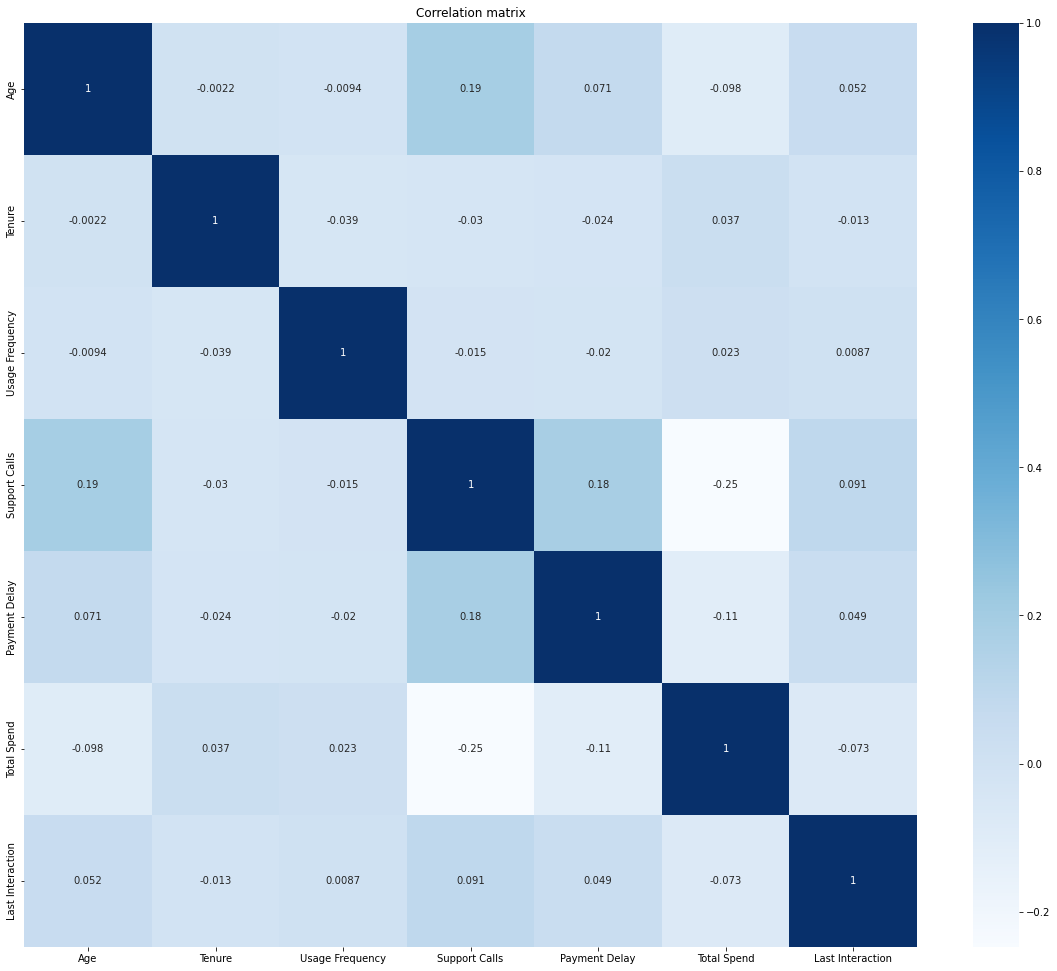

In [118]:
# Checking if numerical features are independant

# Isolating numerical features
X_resamp_numeric = X_resamp[['Age', 'Tenure', 'Usage Frequency', 
                            'Support Calls', 'Payment Delay', 'Total Spend', 
                            'Last Interaction']]

# Plotting correlation matrix
plt.rcParams['figure.figsize'] = (20, 17)
corrmat = X_resamp_numeric.corr()
sns.heatmap(corrmat, annot=True, cbar=True, cmap='Blues') # 'Blues' vmin=-1 vmax=1
plt.title("Correlation matrix")


None of the numerical features are highly correlated with each other; we can keep all of them. Let's do a chi-squared test for the categorical features to test their importance. The higher the chi-squared score, the more important the feature is.

<AxesSubplot:>

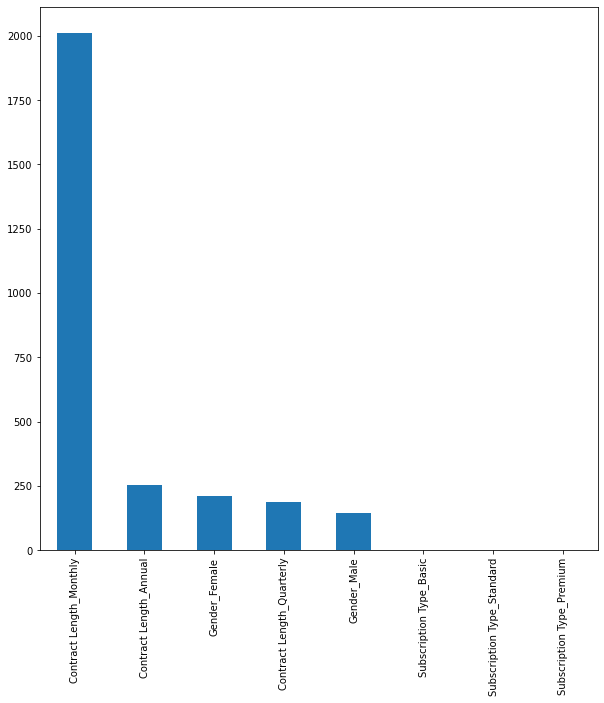

In [119]:
# Isolating categorical features
X_resamp_categorical = X_resamp[['Gender_Female', 'Gender_Male', 'Subscription Type_Basic', 
                                'Subscription Type_Premium', 'Subscription Type_Standard', 
                                'Contract Length_Annual', 'Contract Length_Monthly', 
                                'Contract Length_Quarterly']]

# Calculating and plotting chi-squared scores
chi_scores = chi2(X_resamp_categorical, y_resamp)
plt.rcParams['figure.figsize'] = (10, 10)
chi_values = pd.Series(chi_scores[0], index=X_resamp_categorical.columns)
chi_values.sort_values(ascending=False, inplace=True)
chi_values.plot.bar()

Whether or not customers subscribe to a monthly contracts (represented by the Contract Length_Monthly feature) seems to be a very important categorical predictor of customer churn, whereas subscription types seem to have very little importance. To further inform our decision on which categorical features to remove, we can check for p-values, where a p-value lower than 0.05 indicates that the feature is statistically significant. Let's plot the p-values of the features and see what we get.

<AxesSubplot:>

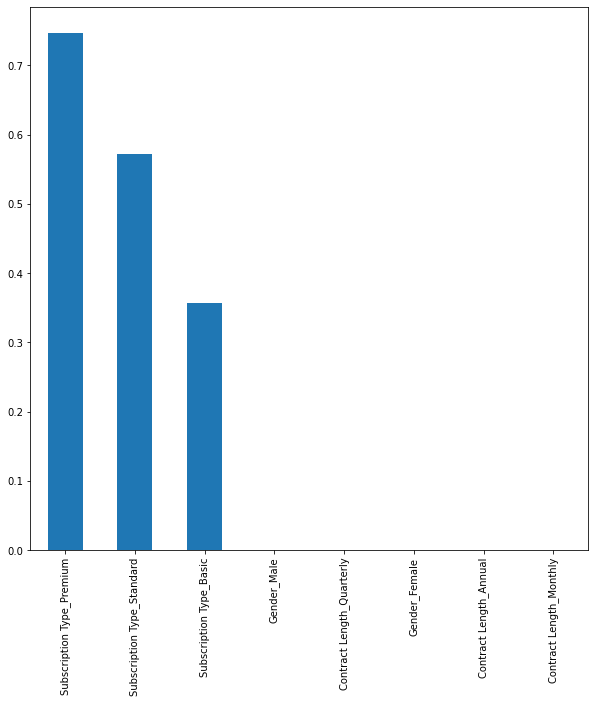

In [120]:
# plotting p-values
plt.rcParams['figure.figsize'] = (10, 10)
p_values = pd.Series(chi_scores[1], index=X_resamp_categorical.columns)
p_values.sort_values(ascending=False, inplace=True)
p_values.plot.bar()

As expected. None of the features related to subscription type are statistically significant. We can remove them.

In [121]:
# remove insignificant features
X_resamp = X_resamp.drop(columns=['Subscription Type_Premium', 'Subscription Type_Standard', 
                                  'Subscription Type_Basic'])

We're ready to begin building our logistic regression model.

### 4.4. Building logistic regression model from scratch

The following tutorials were used as a guide to build the logistic regression class from scratch: 
- Tutorial 1: https://www.askpython.com/python/examples/logistic-regression-from-scratch.
- Tutorial 2: https://www.youtube.com/watch?v=YYEJ_GUguHw

Two of the biggest changes that were made when using the tutorials as guides:
- The code in the first tutorial took data as a parameter at the initialization stage. The code was revamped so that the data is taken at the fitting stage. Defaults for 'lr' (learning rate) and 'iterations' parameters were also added.
- A component from the second tutorial that was added to this code was the accuracy score method.

In [122]:
# Building the logistic regression model

# creating logistic regression class
# methods in this class are only available for use within the class since they are defined within...
# the class.
class LogReg: 
    # creating initialization method using __init__ that will initialize defined attributes when class...
    #  instance is called. The 'lr' (learning rate), C and 'iterations' parameters have been given defaults
    def __init__(self, learning_rate=0.01, iterations=1000, C=1.0): 
        # initializing a placeholder for intercept vector
        self.intercept = None
        # initializing a placeholder for the weights vector
        self.weight = None
        # initializing learning rate
        self.learning_rate = learning_rate
        # initializing number of iterations
        self.iterations = iterations
        # initializing C
        self.C = C

    # creating the sigmoid method that will return a probability that can then be mapped as binary...
    # classes (AskPython, 2020)
    def sigmoid(self, q):
        # sigmoid equation
        sig_prob = 1/(1 + np.exp(-q))
        # returning probability converted from linear equation input (q) 
        return sig_prob
    
    # creating the loss function method that will help us find the best weights where loss is minimized... 
    # (AskPython, 2020)
    def loss(self, h, y):
        # adding an L2 regularization term for loss function (tuned by C)
        reg_term = (1 / (2 * self.C)) * np.sum(np.square(self.weight[1:]))
        # returning calculated loss
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean() + reg_term

    # creating the gradient descent method, where gradient descent is the derivative of the loss function...
    # with respect to the weights (AskPython, 2020). This will help optimize the weights as the logistic...
    # regression model trains on the data
    def gradient_descent(self, X, h, y):
        # calculating gradient
        gradient = np.dot(X.T, (h - y)) / y.shape[0]
        # regularizing weights during gradient descent for more effective regularization
        reg_term = self.weight / self.C
        # Keeping bias terms (intercepts) unregularized
        reg_term[0] = 0
        return gradient + reg_term

    # creating the fit method which trains the model onto the data. 
    def fit(self, x, y):
        # initializing the intercept as a vector of ones based on the number of rows in the data
        self.intercept = np.ones((x.shape[0], 1))
        # concatenating the intercept with x for computational efficiency
        x = np.concatenate((self.intercept, x), axis=1)
        # initializing the weights as a vector of zeros based on the number of columns (features) in...
        # the data
        self.weight = np.zeros(x.shape[1])
        
        # for loop to run training steps over specified number of iterations to gradually adjust weights
        for i in range(self.iterations):
            # calculating the linear model used in sigmoid function using x and weights
            linear_model = np.dot(x, self.weight)
            # inputting linear model into sigmoid function to get probabilities
            sigma = self.sigmoid(linear_model)
            # calculating the loss which takes calculated probabilities and y actual as parameters.
            loss = self.loss(sigma, y)
            # calculating the gradient of the loss function used to update the weights
            dW = self.gradient_descent(x, sigma, y)
            # updating the weights based on the calculated and the specified learning rate
            self.weight -= self.learning_rate * dW

    # creating the predict method used to make predictions on new (testing) data after the logistic...
    # regression model has been trained
    def predict(self, x_new, threshold=0.5):
        # adding the intercept vector/column to the new (test) data
        intercept = np.ones((x_new.shape[0], 1))
        x_new = np.concatenate((intercept, x_new), axis=1)
        # calculating the probabilities using the sigmoid function, this time using the optimized weights
        prediction = self.sigmoid(np.dot(x_new, self.weight))
        # applying the threshold as a boolean expression and converting it into integer form...
        # to convert probabilities into binary class labels
        return (prediction >= threshold).astype(int)
    
    # creating the predict_proba method that will output predicted probabilities when it receives input data
    def predict_proba(self, X):
        # adding the intercept vector/column to the new (test) data
        intercept = np.ones((X.shape[0], 1))
        x_new = np.concatenate((intercept, X), axis=1)
        # calculating the probabilities using the sigmoid function, but not converting them to integers...
        # this time
        probs = self.sigmoid(np.dot(x_new, self.weight))
        return probs
    
    # creating a method that will calculate prediction accuracy
    def accuracy(self, y_pred, y_actual): 
        return np.sum(y_pred==y_actual) / len(y_actual)
    
    # ----------------------------------------------------------------------------------------------

    # The following script was added to make this logistic regression class compatible with GridSearchCV

    # this function retrieves parameter attributes of all trained instance combinations
    def get_params(self, deep=True):
        return {"learning_rate": self.learning_rate, "iterations": self.iterations, "C": self.C}

    # this function updates an instance with its respective parameter attributes
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


### 4.5. Model training, improvement and evaluation

Now that we've built our logistic regression class from scratch, let's see how it performs on our data. We begin by creating our training and testing partitions.

In [123]:
# Creating our training and testing partitions of our feature and target variables
# Stratify ensures that class labels are proportionately distributed between the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resamp, y_resamp, stratify=y_resamp, 
                                                    test_size=0.2, random_state=0)

Now we scale our data for better performance using StandardScaler() from sklearn's preprocessing module

In [124]:
# Instantiating and fitting StandardScaler and standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Let's check the shape of our training and testing partitions.

In [125]:
# Shapes of training and testing partitions
print("Shape of X_train: {}".format(X_train.shape))
print("Shape of X_test: {}".format(X_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (8984, 12)
Shape of X_test: (2246, 12)
Shape of y_train: (8984,)
Shape of y_test: (2246,)


#### 4.5.1. Model training and improvement

Next, we instantiate our model object from the LogReg class we created.

In [126]:
# instantiating LogReg class
logreg = LogReg()

Now, we create a parameter grid for model improvement purposes.

In [127]:
# defining parameter grid
param_grid = {'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5],
              'C': [0.01, 0.1, 1, 10, 100]}

Next, we instantiate and fit a GridSearchCV object to our training data to find the best model parameters for our logistic regression model.

In [128]:
# instantiating and fitting GridSearchCV with 5 fold cross validation
grid = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

/tmp/ipykernel_2381/1583406912.py:35: RuntimeWarning: divide by zero encountered in log
  return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean() + reg_term
/tmp/ipykernel_2381/1583406912.py:25: RuntimeWarning: overflow encountered in exp
  sig_prob = 1/(1 + np.exp(-q))
/tmp/ipykernel_2381/1583406912.py:33: RuntimeWarning: overflow encountered in double_scalars
  reg_term = (1 / (2 * self.C)) * np.sum(np.square(self.weight[1:]))
/home/lab_services_student/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_2381/1583406912.py:33: RuntimeWarning: overflow encountered in square
  reg_term = (1 / (2 * self.C)) * np.sum(np.square(self.weight[1:]))
/tmp/ipykernel_2381/1583406912.py:44: RuntimeWarning: overflow encountered in true_divide
  reg_term = self.weight / self.C
/tmp/ipykernel_2381/1583406912.py:70: RuntimeWarning: invalid value encountered in subt

GridSearchCV(cv=5, estimator=<__main__.LogReg object at 0x7fa0656d5040>,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]},
             scoring='accuracy')

Let's see what the model with the best parameters was, along with it's validation score.

In [129]:
# best parameters
print("Best parameters: {}\nValidation score: {:.4f}".format(grid.best_params_, grid.best_score_))

Best parameters: {'C': 100, 'learning_rate': 0.05}
Validation score: 0.9019


We get an impressive validation score of approximately 90.15% on our training set. Let's investigate the accuracy score on out testing set to see how it compares.

In [130]:
# Test set score
print("Test set score: {:.4f}".format(grid.score(X_test, y_test)))

Test set score: 0.9020


Our model seems to be very well fit looking at how similar our test score is to our validation score. However, accuracy alone is not the best metric for model evaluation. Let's dive depper into our model's classification performance.

#### 4.5.2. Model Evaluation Part 1 - Confusion matrix and classification report

We start off with our confusion matrix, which we can easily create using the confusion_matrix() method from Scikit-learn's metrics module, then plot it using Seaborn's heatmap() method:

Text(0.5, 1.0, 'Confusion Matrix')

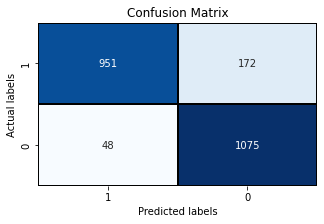

In [131]:
# Confusion matrix
y_pred = grid.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

# Plot confusion matrix
plt.rcParams['figure.figsize'] = (5, 3)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, linecolor='black', linewidth=0.2, 
           xticklabels=[1, 0], yticklabels=[1, 0])
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.title("Confusion Matrix")

From this confusion matrix, we gather that our logistic regression model produced the following classification results on the testing set with regards to predicting customer churn:

- 951 true positives (TP - upper left), which means that it predicted 951 customers to have churned that actually did churn.
- 172 false negatives (FN - upper right), which means that it predicted 172 customers to be non-churned that actually had churned.
- 48 false positives (FP - lower left), which means that it predicted 48 customers to be churned that actually were non-churned.
- 1075 true negatives (TN - lower right), which means that it predicted 1075 customers to be non-churned that actually were non-churned.

The model produced relatively low type 1 and 2 errors (FPs and FNs respectively) in proportion to its TPs and TNs. To better understand this model's performance regarding our goal (investigating how well a logistic regression model built from scratch can predict customer churn), lets take a look at our classification report using the classicifcation_report() method from Scikit-learn's metrics module:

In [132]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1123
           1       0.95      0.85      0.90      1123

    accuracy                           0.90      2246
   macro avg       0.91      0.90      0.90      2246
weighted avg       0.91      0.90      0.90      2246



It is important to note that the classification_report() method calculates precision, recall and the f1-score for both classes as if they were the positive class then averages those values out (per class) using two average metrics (macro and weighted average). Therefore, Class 0's precision and recall are Class 1's negative predictive value and specificity respectively in this case, since we are treating Class 1 as the positive class. Class 0's f1-score can be treated as a harmonic mean between negative predictive value and specificity for Class 1. The metrics are interpreted as follows:

Predictive performance of churned customers:
- Precision: a precision score of 0.95 for Class 1 tells us that out of all the times the logistic regression model predicted a customer to be churned, it made the correct prediction 95% of the time.
- Recall: a recall score of 0.85 for Class 1 tells us that out of all the positive instances in the testing set (that is, out of all the instances where customers churned), the logistic regression model managed to capture 85% of those positive instances (TP + FN).
- F1-score: an f1-score of 0.90 for Class 1 gives us a very strong harmonic mean of this model's predictive power regarding the prediction of Class 1 (taking into account the weaknesses of both precision and recall). This model is very good at predicting churned customers.
<br>

Predictive performance of non-churned customers:
- Negative predictive value: an approximate negative predictive value score of 0.86 for Class 1 (Class 0's precision) tells us that out of all the times the logistic regression model predicted a customer to be non-churned, it made the correct prediction approximately 86% of the time.
- Specificity: a specificity score of 0.96 for Class 1 (Class 0's recall) tells us that out of all the negative instances in the testing set (that is, out of all the instances where customers were non-churned), the logistic regression model managed to capture 96% of those negative instances (TN + FP).
- "Negative class" F1-score: an approximate "negative class" f1-score of 0.91 (Class 0's F1-score) gives us a very strong harmonic mean of this model's predictive power regarding the prediction of Class 0 (taking into account the weaknesses of both negative predictive value and specificity). This model is very good at predicting non-churned customers.

Comparisons: 
- The model has a higher precision (0.95) than it does a negative predictive value (0.86). The model is better at predicting churned customers than it is at predicting non-churned customers.
- The model has a higher specificity (0.96) than it does recall (0.85). The model managed to capture more instances of non-churned customers in the test set than it did instances of churned customers.
- The model has a slightly higher "negative class" (Class 0) f1-score than it does (Class 1) f1-score. Overall, the model's predictive power leans slightly more towards Class 0 in the context of this data set.

#### 4.5.3. Model Evaluation Part 2 - ROC and AUC

As much as we have an idea of how skilful this model is by now, it really helps to plot ROC curves to get an exact understanding of just how skilful our model is. We can create our ROC curve points we will use to plot our graph using the roc_curve() method imported from Scikit-learn's metrics module. As inputs, the method takes in our target variable from our test set (y_test) and its respective predicted probabilities. We start off by creating the predicted probabilities for our logistic regression model (using the predict_proba() method), as well as those of a simulated random classifier.

In [133]:
# simulating probabilities that a random classifier would produce and producing probabilities using...
# X_test for logistic regression model using predict_proba() method
r_probs = [0 for _ in range(len(y_test))] # an absolutely random classifier would very likely get all predictions wrong
logreg_probs = grid.predict_proba(X_test) # this predict_proba method outputs the probs for the positive class

Before we plot the ROC curves of the logistic regression model and the simulated random classifier (as a reference), we now have enough information to calculate our AUC scores for the models using the roc_auc_score() method from Scikit-learn's metrics module.

In [134]:
# AUC scores for classifiers (including simulated random = 0.5 [baseline])
r_auc = roc_auc_score(y_test, r_probs)
logreg_auc = roc_auc_score(y_test, logreg_probs)

print("AUC scores for classifiers:\nSimulated Random Classifier: {:.4f}\nGaussian Naive Bayes: {:.4f}".format(
    r_auc, logreg_auc))

AUC scores for classifiers:
Simulated Random Classifier: 0.5000
Gaussian Naive Bayes: 0.9613


The AUC scores will be used for the graph's legend but just from these scores, we can see just how skillful our logistic regression model is compared to the random classifier. We see the simulated random classifier gets an AUC score of 0.5, of which it should. The logistic regression model gets an AUC of approximately 0.96, which tells us that the logistic regression model is very skillful at discriminating between the positive class and the negative class.

Let's now calculate the TPR and FPR values for our models (that we will need to plot the graph) using the roc_curve() method.


In [135]:
# Calculating ROC curve points
# Thresholds for tweaking tpr/fpr rate accordingly
r_fpr, r_tpr, thresholds = roc_curve(y_test, r_probs)
logreg_fpr, logreg_tpr, thresholds = roc_curve(y_test, logreg_probs)

We can now plot our ROC curves to visualize the AUC results using Matplotlib's pyplot module.

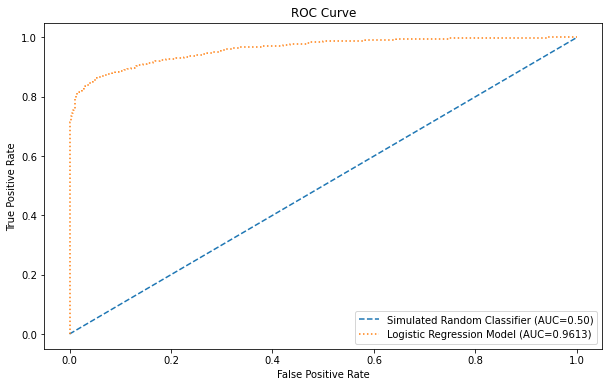

In [136]:
# Plotting ROC curve
plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(r_fpr, r_tpr, linestyle='--', label='Simulated Random Classifier (AUC={:.2f})'.format(r_auc))
plt.plot(logreg_fpr, logreg_tpr, linestyle='dotted', label='Logistic Regression Model (AUC={:.4f})'.format(logreg_auc))

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

## 5. Conclusion

The objectives of the analysis that were succesfully completed are as follows:
- A thorough data cleaning and exploratory data analysis was conducted before using the data for model training purposes.
- A functional logistic regression class was built from scratch. 
- The logistic regression model was successfully trained and any necessary model improvement techniques were successfully applied.
- The necessary model evaluation classification metrics were calculated, interpreted and understood. 

## 6. References

1. Amazon Web Services. 2024. What is Logistic Regression?, 2024. [Online]. Available at: https://aws.amazon.com/what-is/logistic-regression/
2. Career Foundry. 2023. What Is Data Cleaning and Why Does It Matter?, 14 September 2023. [Online]. Available at: https://careerfoundry.com/en/blog/data-analytics/what-is-data-cleaning/
3. Medium. 2023. Introduction to Balanced and Imbalanced Datasets in Machine Learning, 9 August 2023. [Online]. Available at: https://medium.com/cord-tech/introduction-to-balanced-and-imbalanced-datasets-in-machine-learning-be60c6eeb8be
4. Investopedia. 2024. Multicollinearity: Meaning, Examples, and FAQs, 29 March 2024. [Online]. Available at: https://www.investopedia.com/terms/m/multicollinearity.asp
5. Domino Data Lab. 2024. PySpark, 2024. [Online]. Available at: https://domino.ai/data-science-dictionary/pyspark
6. AskPython. 2020. Logistic Regression From Scratch in Python [Algorithm Explained], 31 December 2020. [Online]. Available at: https://www.askpython.com/python/examples/logistic-regression-from-scratch